In [ ]:
from dotenv import load_dotenv
import os

# Load environment variables from .env file

load_dotenv()

# Retrieve the API key
openai_api_key = os.getenv('OPENAI_API_KEY')

In [3]:
### Fast summarizer
from transformers import pipeline
import pdfplumber
import textwrap

# Initialize the Hugging Face summarization pipeline with a pre-trained model
summarizer = pipeline("summarization", model="sshleifer/distilbart-cnn-12-6")

def split_text(text, max_tokens):
    """
    Splits the text into chunks of a specified maximum token length.

    Args:
    - text (str): The text to split.
    - max_tokens (int): The maximum number of tokens for each chunk.

    Returns:
    - list: A list of text chunks.
    """
    chunks = textwrap.wrap(text, width=max_tokens)
    return chunks

def summarize_text(text, max_tokens=512):
    """
    Summarizes the input text using a pre-trained transformer model.

    Args:
    - text (str): The text to summarize.
    - max_tokens (int): The maximum number of tokens for each chunk.

    Returns:
    - str: The summarized text.
    """
    chunks = split_text(text, max_tokens)
    summarized_chunks = []
    for chunk in chunks:
        summarized_chunk = summarizer(chunk, max_length=150, min_length=30, do_sample=False)
        summarized_chunks.append(summarized_chunk[0]['summary_text'])
    # Concatenate and summarize the summarized chunks into a final summary
    final_summary = summarizer(" ".join(summarized_chunks), max_length=150, min_length=30, do_sample=False)
    return final_summary[0]['summary_text']

def extract_text_from_pdf(pdf_path):
    """
    Extracts text from a PDF file.

    Args:
    - pdf_path (str): Path to the PDF file.

    Returns:
    - str: The extracted text from the PDF.
    """
    text = ""
    with pdfplumber.open(pdf_path) as pdf:
        for page in pdf.pages:
            text += page.extract_text()
    return text


# Sample text for summarization
sample_text = """
The field of machine learning has seen rapid advancements over the past few decades. With the advent of deep learning, models have become increasingly complex and capable of handling a wide variety of tasks. One of the key areas where machine learning has made significant strides is natural language processing (NLP). NLP encompasses a range of tasks such as text classification, sentiment analysis, machine translation, and summarization.

Recent developments in transformer models have revolutionized NLP. The introduction of models such as BERT, GPT-3, and BART has led to state-of-the-art performance on numerous benchmarks. These models leverage large-scale pre-training on vast amounts of text data followed by fine-tuning on specific tasks. As a result, they can understand and generate human language with remarkable accuracy.

However, with the increasing size of these models, computational requirements have also skyrocketed. Training and deploying these models necessitates significant computational resources, including powerful GPUs and TPUs. This has led to the exploration of more efficient model architectures and techniques to reduce the resource footprint without sacrificing performance.

In conclusion, the advancements in machine learning and NLP are truly transformative. The ability to process and understand human language opens up countless possibilities for applications across various domains. As research in this field continues, we can expect even more innovative solutions that push the boundaries of what is possible with machine learning.
"""

# Summarize the sample text
summary = summarize_text(sample_text, max_tokens=512)
print("Summary of the sample text:")
print(summary)

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.
Your max_length is set to 150, but your input_length is only 94. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=47)
Your max_length is set to 150, but your input_length is only 100. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 150, but your input_length is only 85. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=42)
Your max_length is set to 150, but your input_length is only 11. Since this is a summarization task, where

Summary of the sample text:
 Machine learning has made significant strides in natural language processing (NLP) NLP encompasses a range of tasks such as text classification, sentiment analysis, machine translation and summarization .


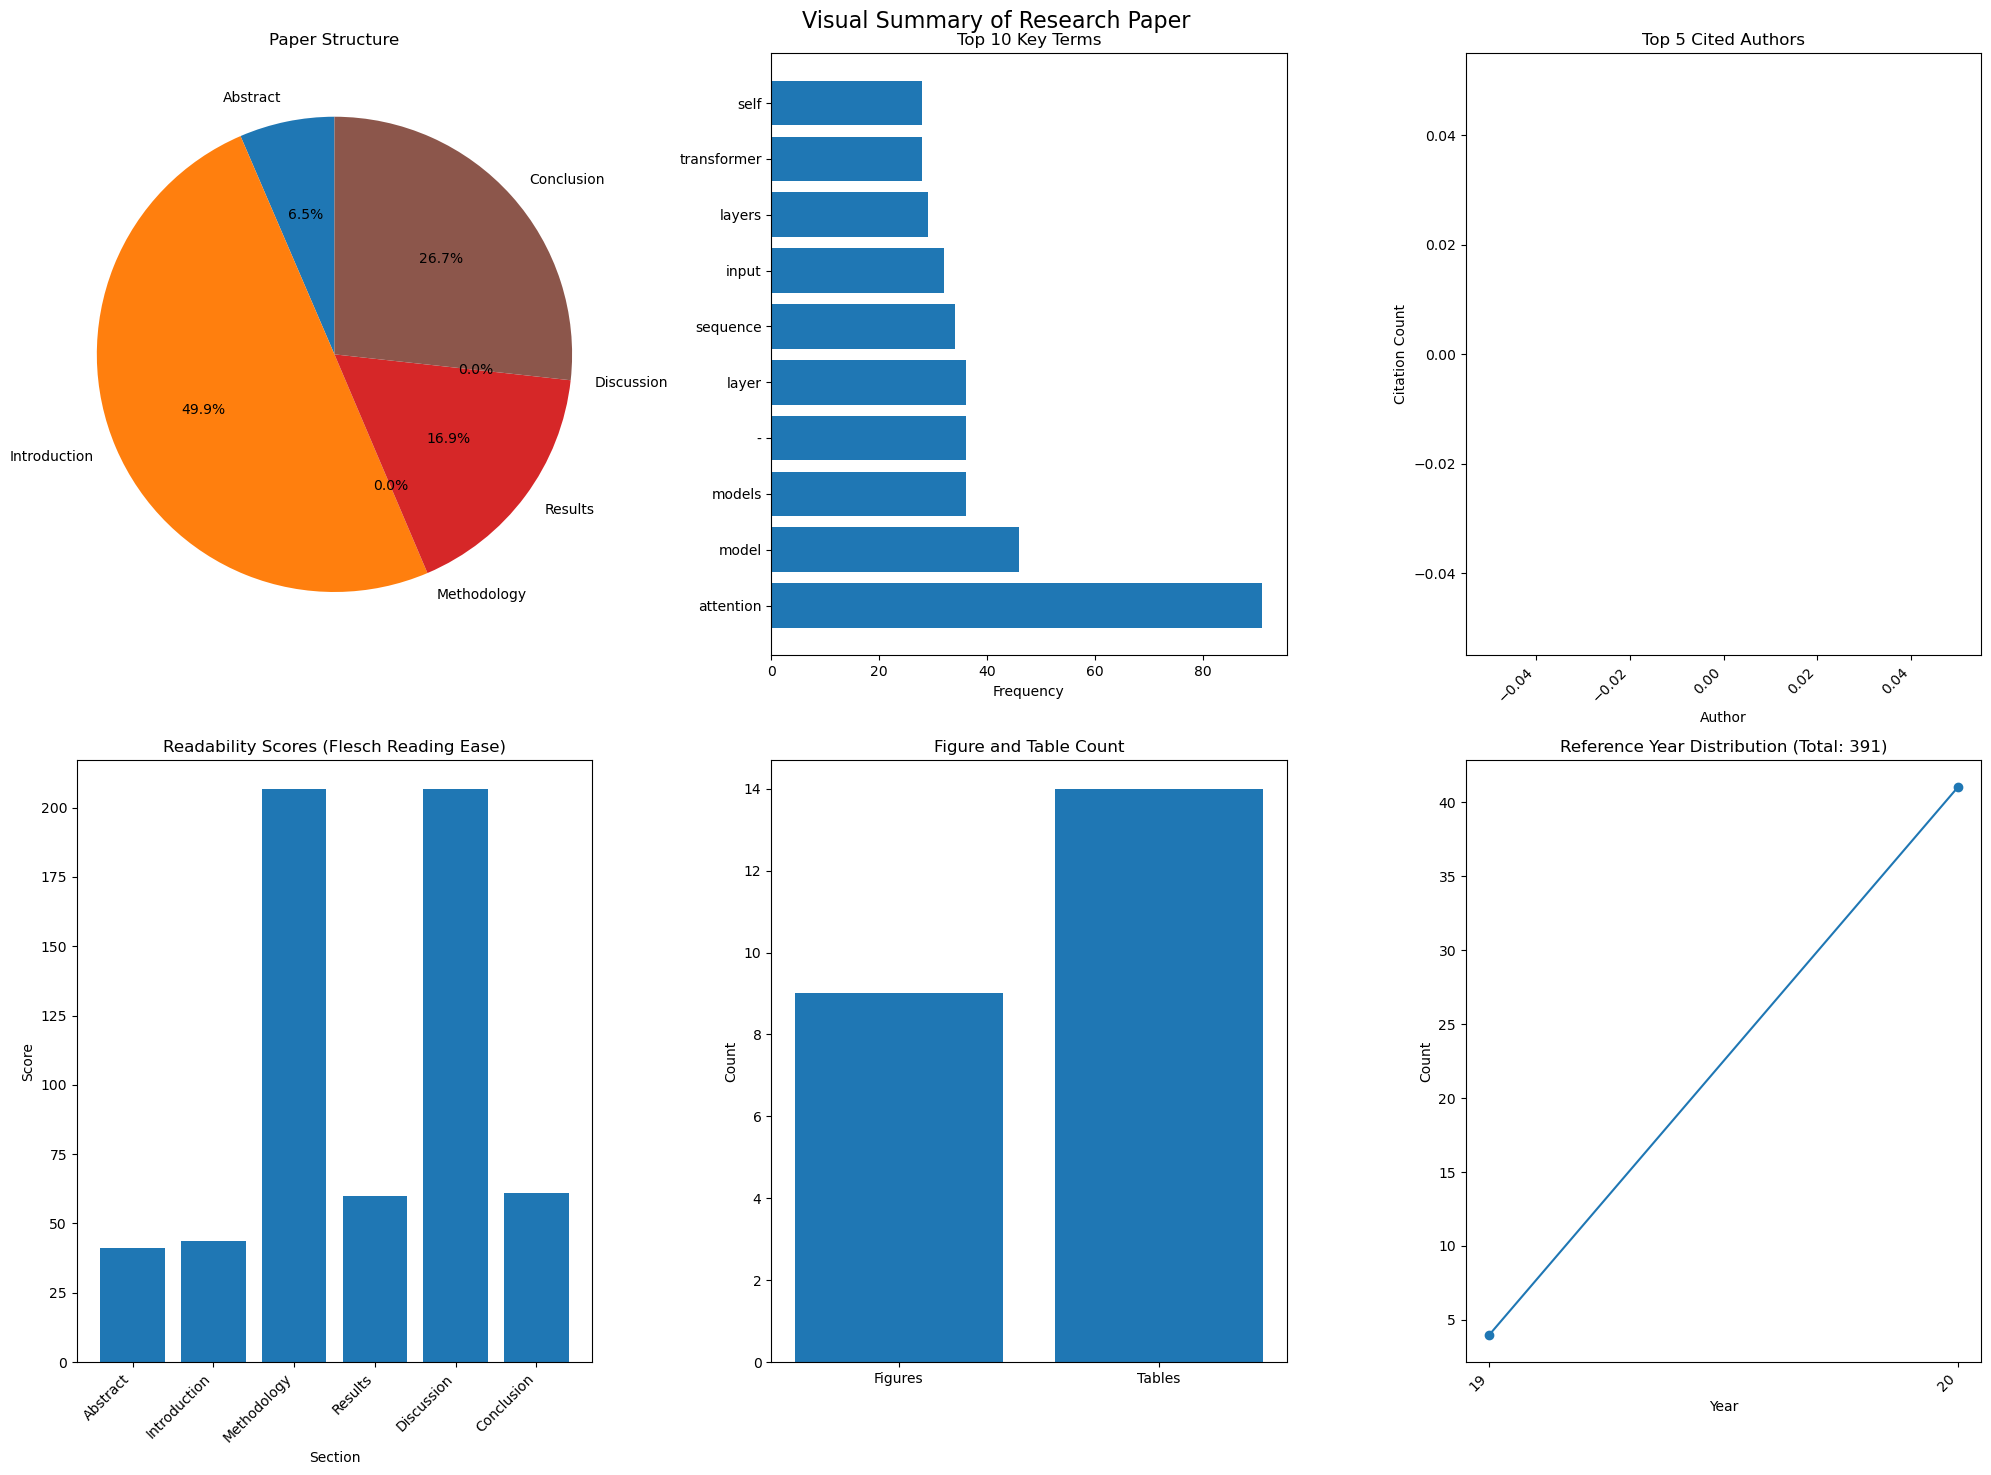

In [36]:

import PyPDF2
import spacy
import matplotlib.pyplot as plt
import re
from collections import Counter
import numpy as np
from textstat import flesch_reading_ease, flesch_kincaid_grade

def extract_text_from_pdf(pdf_path):
    with open(pdf_path, 'rb') as file:
        reader = PyPDF2.PdfReader(file)
        text = ""
        for page in reader.pages:
            text += page.extract_text()
    return text

def process_text(text):
    nlp = spacy.load("en_core_web_sm")
    doc = nlp(text)
    return doc

def extract_key_elements(doc):
    sections = {
        "Abstract": "",
        "Introduction": "",
        "Methodology": "",
        "Results": "",
        "Discussion": "",
        "Conclusion": ""
    }
    
    current_section = "Abstract"
    for sent in doc.sents:
        if any(section in sent.text for section in sections.keys()):
            current_section = next(section for section in sections.keys() if section in sent.text)
        sections[current_section] += sent.text + " "
    
    return sections

def extract_key_terms(doc, n=10):
    important_pos = ['NOUN', 'PROPN', 'ADJ']
    words = [token.text.lower() for token in doc if token.pos_ in important_pos and not token.is_stop]
    return Counter(words).most_common(n)

def extract_citations(text):
    citation_pattern = r'\(([^)]+, \d{4}[a-z]?)\)'
    return re.findall(citation_pattern, text)

def count_figures_and_tables(text):
    figure_count = len(re.findall(r'Figure \d+', text, re.IGNORECASE))
    table_count = len(re.findall(r'Table \d+', text, re.IGNORECASE))
    return figure_count, table_count

def analyze_references(text):
    reference_section = text.split('References')[-1]
    reference_count = len(re.findall(r'\n', reference_section))
    years = re.findall(r'\b(19|20)\d{2}\b', reference_section)
    return reference_count, years

def create_visual_summary(sections, key_terms, citations, fig_table_count, ref_analysis):
    fig = plt.figure(figsize=(20, 15))
    fig.suptitle("Visual Summary of Research Paper", fontsize=16)

    # Paper Structure
    ax1 = fig.add_subplot(231)
    sizes = [len(content.split()) for content in sections.values()]
    labels = list(sections.keys())
    ax1.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
    ax1.axis('equal')
    ax1.set_title("Paper Structure")

    # Key Terms
    ax2 = fig.add_subplot(232)
    terms, counts = zip(*key_terms)
    ax2.barh(terms, counts)
    ax2.set_title("Top 10 Key Terms")
    ax2.set_xlabel("Frequency")

    # Citation Network
    ax3 = fig.add_subplot(233)
    citation_counts = Counter(citations)
    top_citations = citation_counts.most_common(5)
    ax3.bar([cite for cite, _ in top_citations], [count for _, count in top_citations])
    ax3.set_title("Top 5 Cited Authors")
    ax3.set_xlabel("Author")
    ax3.set_ylabel("Citation Count")
    plt.setp(ax3.xaxis.get_majorticklabels(), rotation=45, ha="right")

    # Readability Scores
    ax4 = fig.add_subplot(234)
    readability_scores = [flesch_reading_ease(section) for section in sections.values()]
    ax4.bar(sections.keys(), readability_scores)
    ax4.set_title("Readability Scores (Flesch Reading Ease)")
    ax4.set_xlabel("Section")
    ax4.set_ylabel("Score")
    plt.setp(ax4.xaxis.get_majorticklabels(), rotation=45, ha="right")

    # Figure and Table Count
    ax5 = fig.add_subplot(235)
    ax5.bar(['Figures', 'Tables'], fig_table_count)
    ax5.set_title("Figure and Table Count")
    ax5.set_ylabel("Count")

    # Reference Year Distribution
    ax6 = fig.add_subplot(236)
    year_counts = Counter(ref_analysis[1])
    years = sorted(year_counts.keys())
    counts = [year_counts[year] for year in years]
    ax6.plot(years, counts, marker='o')
    ax6.set_title(f"Reference Year Distribution (Total: {ref_analysis[0]})")
    ax6.set_xlabel("Year")
    ax6.set_ylabel("Count")
    plt.setp(ax6.xaxis.get_majorticklabels(), rotation=45, ha="right")

    plt.tight_layout()
    plt.show()

# Main execution
pdf_path = "example_research_paper.pdf"
text = extract_text_from_pdf(pdf_path)
doc = process_text(text)
sections = extract_key_elements(doc)
key_terms = extract_key_terms(doc)
citations = extract_citations(text)
fig_table_count = count_figures_and_tables(text)
ref_analysis = analyze_references(text)
create_visual_summary(sections, key_terms, citations, fig_table_count, ref_analysis)

In [107]:
import json
import os
import PyPDF2
import tiktoken
from openai import OpenAI

# Initialize OpenAI client
client = OpenAI(api_key=openai_api_key)

def extract_text_from_pdf(pdf_path):
    """Extract text from a PDF file."""
    with open(pdf_path, 'rb') as file:
        reader = PyPDF2.PdfReader(file)
        text = ""
        for page in reader.pages:
            text += page.extract_text() or ""
    return text

def num_tokens_from_string(string: str, encoding_name: str = "cl100k_base") -> int:
    """Calculate the number of tokens in a string."""
    encoding = tiktoken.get_encoding(encoding_name)
    return len(encoding.encode(string))

def chunk_text(text, max_tokens=3000):
    """Split text into chunks of specified maximum token length."""
    chunks = []
    current_chunk = ""
    current_tokens = 0
    
    for sentence in text.split('.'):
        sentence_tokens = num_tokens_from_string(sentence)
        if current_tokens + sentence_tokens > max_tokens:
            chunks.append(current_chunk)
            current_chunk = sentence
            current_tokens = sentence_tokens
        else:
            current_chunk += sentence + '.'
            current_tokens += sentence_tokens
    
    if current_chunk:
        chunks.append(current_chunk)
    
    return chunks

def generate_pytorch_code(paper_text):
    """Generate PyTorch code snippets based on the paper text."""
    chunks = chunk_text(paper_text)
    all_snippets = []

    for i, chunk in enumerate(chunks):
        try:
            response = client.chat.completions.create(
                model="gpt-3.5-turbo",
                messages=[
                    {"role": "system", "content": "You are an AI assistant that generates PyTorch code snippets based on machine learning research papers. Provide each code snippet as a separate message."},
                    {"role": "user", "content": f"Generate PyTorch code snippets for the following paper text (part {i+1}/{len(chunks)}):\n\n{chunk}"}
                ],
                temperature=0.7,
            )
            
            # Process each message in the response
            for choice in response.choices:
                content = choice.message.content.strip()
                # Check if the content looks like code
                if content.startswith('```python') and content.endswith('```'):
                    # Extract code between backticks
                    code = content.split('```')[1].strip()
                    all_snippets.append({"code": code})
                elif '=' in content or 'def ' in content or 'class ' in content:
                    # If it looks like code but isn't wrapped in backticks
                    all_snippets.append({"code": content})
        
        except Exception as e:
            print(f"Error processing chunk {i+1}: {str(e)}")

    return all_snippets

def save_json_to_file(data, file_name):
    """Save JSON data to a file."""
    try:
        with open(file_name, 'w') as f:
            json.dump(data, f, indent=2)
        print(f"{file_name} saved successfully.")
    except Exception as e:
        print(f"Failed to save {file_name}: {str(e)}")

def main():
    pdf_path = "example_research_paper.pdf"
    output_file = "pytorch_code_snippets.json"

    # Extract text from PDF
    print("Extracting text from PDF...")
    paper_text = extract_text_from_pdf(pdf_path)

    # Generate PyTorch code snippets
    print("Generating PyTorch code snippets...")
    code_snippets = generate_pytorch_code(paper_text)

    # Save code snippets to JSON file
    print("Saving code snippets to JSON file...")
    save_json_to_file({"code_snippets": code_snippets}, output_file)

if __name__ == "__main__":
    main()

Extracting text from PDF...
Generating PyTorch code snippets...
Saving code snippets to JSON file...
pytorch_code_snippets.json saved successfully.


Generating concept hierarchy...
Concept hierarchy saved to concept_hierarchy.json


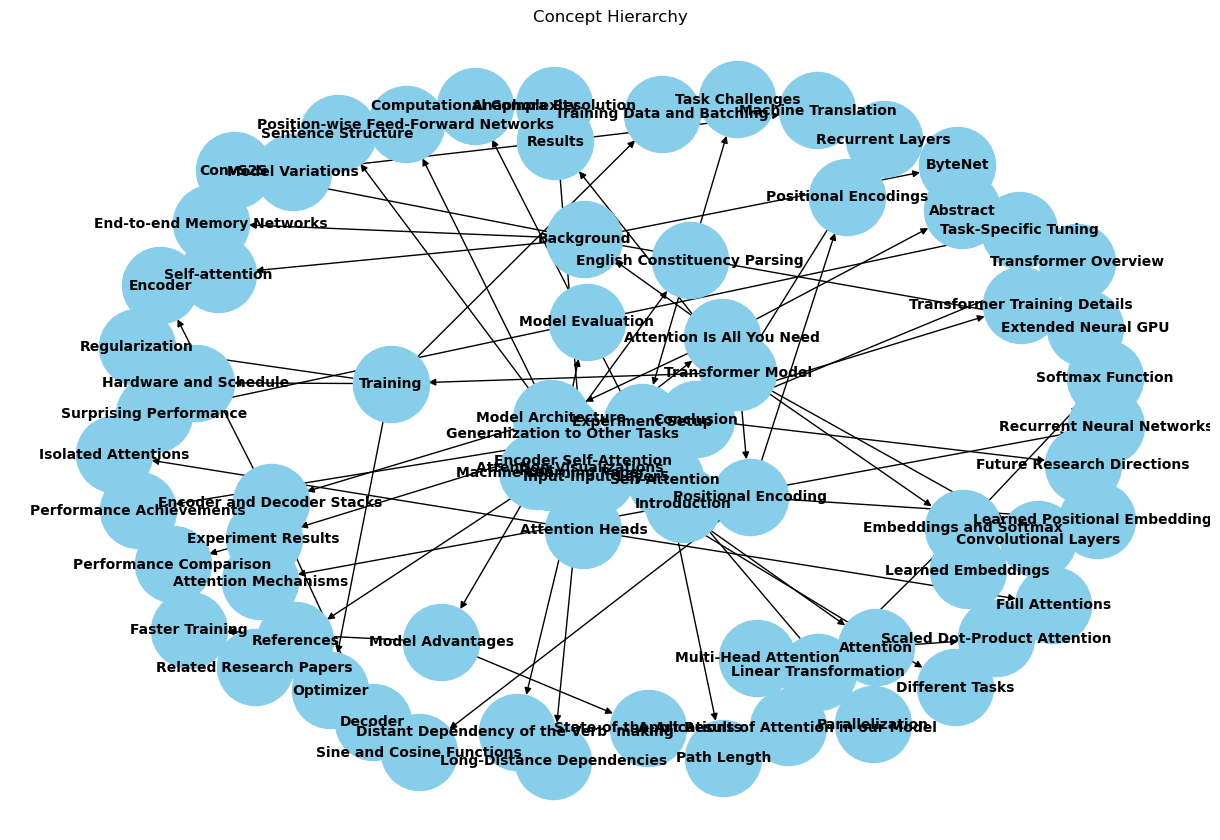

concept_hierarchy.html
Process completed.


In [87]:
# Finalized concept mapping
import json
import re
import os
import networkx as nx
from matplotlib import pyplot as plt
from pyvis.network import Network
import PyPDF2
import tiktoken
from openai import OpenAI

# Initialize the OpenAI client
client = OpenAI(api_key=openai_api_key)

def extract_text_from_pdf(pdf_path):
    try:
        with open(pdf_path, 'rb') as file:
            reader = PyPDF2.PdfReader(file)
            text = ""
            for page in reader.pages:
                text += page.extract_text()
        return text
    except Exception as e:
        print(f"Error extracting text from PDF: {str(e)}")
        return ""

def num_tokens_from_string(string: str, encoding_name: str) -> int:
    encoding = tiktoken.get_encoding(encoding_name)
    num_tokens = len(encoding.encode(string))
    return num_tokens

def chunk_text(text, max_tokens=3000):
    chunks = []
    current_chunk = ""
    current_tokens = 0
    
    for sentence in text.split('.'):
        sentence_tokens = num_tokens_from_string(sentence, "cl100k_base")
        if current_tokens + sentence_tokens > max_tokens:
            chunks.append(current_chunk)
            current_chunk = sentence
            current_tokens = sentence_tokens
        else:
            current_chunk += sentence + '.'
            current_tokens += sentence_tokens
    
    if current_chunk:
        chunks.append(current_chunk)
    
    return chunks

def get_completion(messages):
    try:
        response = client.chat.completions.create(
            model="gpt-3.5-turbo",
            messages=messages,
            temperature=0.7,
        )
        return response.choices[0].message.content.strip()
    except Exception as e:
        print(f"Error getting completion from OpenAI: {str(e)}")
        return ""

def concept_hierarchy_generator(text):
    chunks = chunk_text(text)
    full_response = ""
    
    for i, chunk in enumerate(chunks):
        messages = [
            {"role": "system", "content": "You are an AI assistant that helps analyze machine learning research papers."},
            {"role": "user", "content": f"""Generate a hierarchical structure of key concepts from this machine learning paper. 
            Organize them from general to specific, showing relationships between concepts. 
            Use a simple indented list format where each level is indented with two spaces more than its parent.
            Start each concept with a dash (-).

            Example format:
            - Main Concept
              - Sub Concept 1
                - Sub Sub Concept A
                - Sub Sub Concept B
              - Sub Concept 2
                - Sub Sub Concept C

            Paper text (part {i+1}/{len(chunks)}):\n{chunk}"""}
        ]
        response = get_completion(messages)
        full_response += response + "\n\n"
    
    # Convert the indented list to JSON
    return indented_list_to_json(full_response)

def indented_list_to_json(text):
    lines = text.split('\n')
    root = {"name": "Root", "children": []}
    stack = [root]
    prev_indent = -1

    for line in lines:
        match = re.match(r'(\s*)- (.+)', line)
        if match:
            indent = len(match.group(1))
            concept = match.group(2).strip()

            while indent <= prev_indent:
                stack.pop()
                prev_indent -= 2

            node = {"name": concept, "children": []}
            stack[-1]["children"].append(node)
            stack.append(node)
            prev_indent = indent

    # Remove empty children lists
    def clean_empty(node):
        if "children" in node:
            node["children"] = [clean_empty(child) for child in node["children"] if child["name"]]
            if not node["children"]:
                del node["children"]
        return node

    clean_empty(root)

    # Ensure there's always at least one concept
    if not root["children"]:
        root["children"] = [{"name": "No specific concepts identified"}]

    return json.dumps(root, indent=2)

def save_to_json_file(data, filename):
    try:
        with open(filename, 'w') as f:
            json.dump(json.loads(data), f, indent=2)
        print(f"Concept hierarchy saved to {filename}")
    except Exception as e:
        print(f"Error saving to JSON file: {str(e)}")

def visualize_concept_hierarchy(json_data):
    def add_edges(graph, node, parent=None):
        if parent:
            graph.add_edge(parent, node['name'])
        for child in node.get('children', []):
            add_edges(graph, child, node['name'])

    hierarchy = json.loads(json_data)
    G = nx.DiGraph()
    add_edges(G, hierarchy)

    # Plot using matplotlib
    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True, node_size=3000, node_color="skyblue", font_size=10, font_weight="bold", arrows=True)
    plt.title("Concept Hierarchy")
    plt.show()

    # Plot using pyvis
    net = Network(notebook=True)
    net.from_nx(G)
    net.show("concept_hierarchy.html")

# Main execution
pdf_path = "example_research_paper.pdf"
output_file = "concept_hierarchy.json"

paper_text = extract_text_from_pdf(pdf_path)

if paper_text:
    print("Generating concept hierarchy...")
    concept_hierarchy = concept_hierarchy_generator(paper_text)
    
    if concept_hierarchy:
        save_to_json_file(concept_hierarchy, output_file)
        visualize_concept_hierarchy(concept_hierarchy)
    else:
        print("Failed to generate concept hierarchy. Saving default structure.")
        default_hierarchy = json.dumps({"name": "Root", "children": [{"name": "No concepts could be extracted"}]})
        save_to_json_file(default_hierarchy, output_file)
        visualize_concept_hierarchy(default_hierarchy)
else:
    print("No text could be extracted from the PDF. Saving default structure.")
    default_hierarchy = json.dumps({"name": "Root", "children": [{"name": "No text extracted from PDF"}]})
    save_to_json_file(default_hierarchy, output_file)
    visualize_concept_hierarchy(default_hierarchy)

print("Process completed.")
